==== Single train/val split ====
Epoch  1: train 0.8063  val 0.7377  AUC 0.9038
Epoch 10: train 0.1489  val 0.1852  AUC 0.9914
Epoch 20: train 0.0821  val 0.1219  AUC 0.9944
Epoch 30: train 0.0622  val 0.0997  AUC 0.9960
Epoch 40: train 0.0525  val 0.0902  AUC 0.9967
Epoch 50: train 0.0454  val 0.0813  AUC 0.9967

Model saved to D:\Project\breast_cancer_smallnet.pth


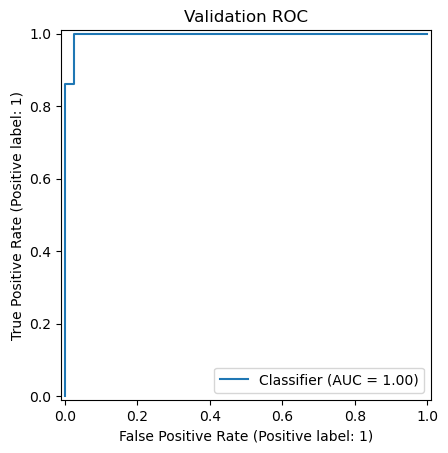


==== k-Fold Cross-Validation ====
Fold 1: AUC = 0.9993
Fold 2: AUC = 0.9984
Fold 3: AUC = 0.9848
Fold 4: AUC = 1.0000
Fold 5: AUC = 0.9987

5-fold mean AUC = 0.9962 ± 0.0057


In [ ]:
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from pathlib import Path

# 0. Hyper-parameters
# Adjust these values to experiment with different training settings.

BATCH_SIZE  = 32
EPOCHS      = 50
LR          = 1e-3
KFOLDS      = 5
MODEL_PATH  = Path("breast_cancer_smallnet.pth")

# 1. Utility Classes & Functions
class SmallNet(nn.Module):
    """A minimal 2-layer fully connected network."""
    def __init__(self, in_dim: int = 30, hid_dim: int = 16, out_dim: int = 2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)


def train_one_epoch(model, loader, criterion, optimizer, device):
    """Single training pass over `loader`."""
    model.train()
    running = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * xb.size(0)
    return running / len(loader.dataset)


@torch.inference_mode()
def evaluate(model, loader, criterion, device):
    """Evaluate loss and collect predicted probabilities + true labels."""
    model.eval()
    loss, probs, y_true = 0.0, [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        loss += criterion(out, yb).item() * xb.size(0)
        probs.extend(torch.softmax(out, 1)[:, 1].cpu().numpy())
        y_true.extend(yb.cpu().numpy())
    return (
        loss / len(loader.dataset),
        np.array(probs),
        np.array(y_true),
    )


def make_loader(X, y, bs, shuffle=False):
    """Wrap NumPy arrays as a PyTorch `DataLoader`."""
    ds = TensorDataset(
        torch.tensor(X, dtype=torch.float32),
        torch.tensor(y, dtype=torch.long),
    )
    return DataLoader(ds, batch_size=bs, shuffle=shuffle)

# 2. Single Split: Train ▸ Save ▸ ROC-AUC
def single_run():
    data = load_breast_cancer(as_frame=True)
    X, y = data.data.values, data.target.values
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    scaler = StandardScaler().fit(X_train)
    X_train, X_val = scaler.transform(X_train), scaler.transform(X_val)

    train_loader = make_loader(X_train, y_train, BATCH_SIZE, shuffle=True)
    val_loader   = make_loader(X_val,   y_val,   BATCH_SIZE)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = SmallNet(in_dim=X.shape[1]).to(device)
    crit   = nn.CrossEntropyLoss()
    opt    = optim.Adam(model.parameters(), lr=LR)

    for ep in range(1, EPOCHS + 1):
        tloss = train_one_epoch(model, train_loader, crit, opt, device)
        if ep == 1 or ep % 10 == 0:
            vloss, vprob, vtrue = evaluate(model, val_loader, crit, device)
            auc = roc_auc_score(vtrue, vprob)
            print(f"Epoch {ep:>2}: train {tloss:.4f}  val {vloss:.4f}  AUC {auc:.4f}")

    # Save model weights + scaler statistics
    torch.save(
        {
            "model": model.state_dict(),
            "scaler_mean": scaler.mean_,
            "scaler_var":  scaler.var_,
        },
        MODEL_PATH,
    )
    print(f"\nModel saved to {MODEL_PATH.resolve()}")

    # ROC curve
    RocCurveDisplay.from_predictions(vtrue, vprob)
    plt.title("Validation ROC")
    plt.show()

# 3. k-Fold Cross-Validation
def kfold_cv():
    data = load_breast_cancer()
    X, y = data.data, data.target
    skf  = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=42)
    aucs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        scaler = StandardScaler().fit(X[train_idx])
        X_tr, X_val = scaler.transform(X[train_idx]), scaler.transform(X[val_idx])
        y_tr, y_val = y[train_idx], y[val_idx]

        train_loader = make_loader(X_tr,  y_tr,  BATCH_SIZE, shuffle=True)
        val_loader   = make_loader(X_val, y_val, BATCH_SIZE)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model  = SmallNet(in_dim=X.shape[1]).to(device)
        crit   = nn.CrossEntropyLoss()
        opt    = optim.Adam(model.parameters(), lr=LR)

        for _ in range(EPOCHS):
            train_one_epoch(model, train_loader, crit, opt, device)

        _, vprob, vtrue = evaluate(model, val_loader, crit, device)
        auc  = roc_auc_score(vtrue, vprob)
        aucs.append(auc)
        print(f"Fold {fold}: AUC = {auc:.4f}")

    print(f"\n{KFOLDS}-fold mean AUC = {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

# 4. Script Entry Point
if __name__ == "__main__":
    print("==== Single train/val split ====")
    single_run()

    print("\n==== k-Fold Cross-Validation ====")
    kfold_cv()
